In [140]:
import tensorflow as tf
import os

DATA_ROOT = "/home/jusun/shared/covid_dataset_combined"
POSITIVE_ROOT = DATA_ROOT + "/positive"
NEGATIVE_ROOT = DATA_ROOT + "/negative"
FORMATS = ('.png', '.jpg', '.jpeg')

In [141]:
def clean_file_name(file_name):
    if file_name.startswith('.'):
        return file_name[1:]
    else:
        return file_name

def load_base_data():
    positive_examples = [POSITIVE_ROOT + '/' + clean_file_name(f) for f in os.listdir(POSITIVE_ROOT) if f.lower().endswith(FORMATS)]
    negative_examples = [NEGATIVE_ROOT + '/' + clean_file_name(f) for f in os.listdir(NEGATIVE_ROOT) if f.lower().endswith(FORMATS)]
    y = [1]*len(positive_examples)+[0]*len(negative_examples)
    return positive_examples + negative_examples, y

In [142]:
image_paths, labels = load_base_data()

In [143]:
epoch_size = len(image_paths)

In [144]:
image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
labels = tf.convert_to_tensor(labels)

In [145]:
print(image_paths.shape)

(3177,)


In [146]:
print(labels.shape)

(3177,)


In [147]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [148]:
def map_fn(path, label):
    # path/label represent values for a single example
    image = tf.image.decode_jpeg(tf.io.read_file(path))
    return image, label

dataset = dataset.map(map_fn).shuffle(1000)

In [149]:
batch_size = 32
epochs = 15
IMG_HEIGHT = 362
IMG_WIDTH = 256

In [165]:
train_data_gen = dataset.take(2500).batch(32)
test_data_gen = dataset.skip(2500).batch(677)

In [214]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [160]:
# plotImages(sample_training_images[:5])

In [161]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

In [162]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [163]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [183]:
for epoch in range(epochs):
    for batch_images, labels in train_data_gen:
        model.train_on_batch(batch_images, labels)

In [184]:
y_true = None
y_pred = None
for batch_images, labels in test_data_gen:
    y_true = labels
    y_pred = model.predict(batch_images)
    model.evaluate(batch_images, labels)

677/677 [==============================] - 10s 14ms/sample - loss: 0.0120 - accuracy: 0.9956

In [185]:
from sklearn.metrics import confusion_matrix

In [186]:
y_pred_mod = [0 if a[0] < 0 else 1 for a in y_pred]

In [187]:
y_pred_mod = tf.convert_to_tensor(y_pred_mod)

In [188]:
confusion_matrix(y_true, y_pred_mod)

array([[664,   2],
       [  0,  11]])

In [193]:
from sklearn.metrics import precision_recall_curve, auc

In [194]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_mod)
area = auc(recall, precision)

In [195]:
print(area)

0.9230769230769231


In [196]:
correctly_classified_covid = []
for i in range(len(y_pred_mod)):
    if y_pred_mod[i] == 1 and y_pred_mod[i] == y_true[i]:
        correctly_classified_covid.append(i)

In [197]:
len(correctly_classified_covid)

11

In [198]:
correctly_classified_covid

[52, 169, 174, 231, 248, 259, 298, 351, 477, 534, 642]

In [203]:
correctly_classified_images = None
for test_images, label in test_data_gen:
    correctly_classified_images = tf.gather(test_images, indices=correctly_classified_covid, axis=0)

In [204]:
print(correctly_classified_images.shape)

(11, 256, 362, 1)


In [206]:
correctly_classified_images = tf.reshape(correctly_classified_images, (11, IMG_WIDTH, IMG_HEIGHT))

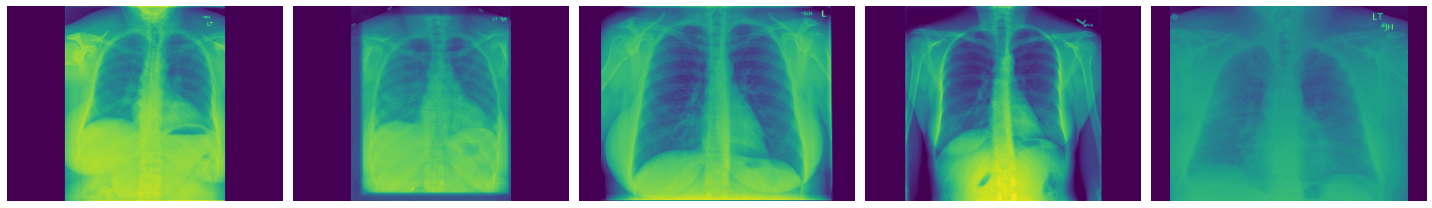

In [207]:
plotImages(correctly_classified_images[:5])

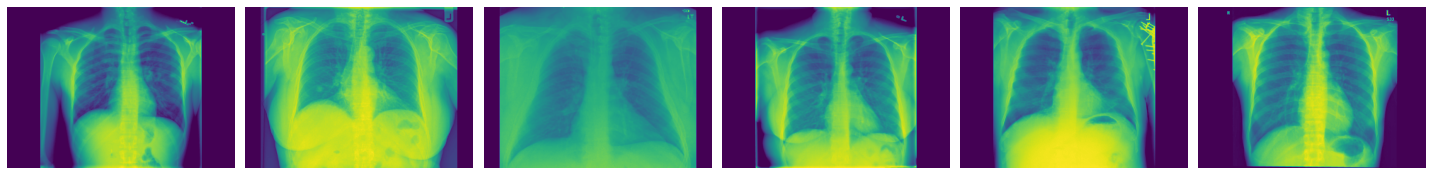

In [217]:
plotImages(correctly_classified_images[5:11])

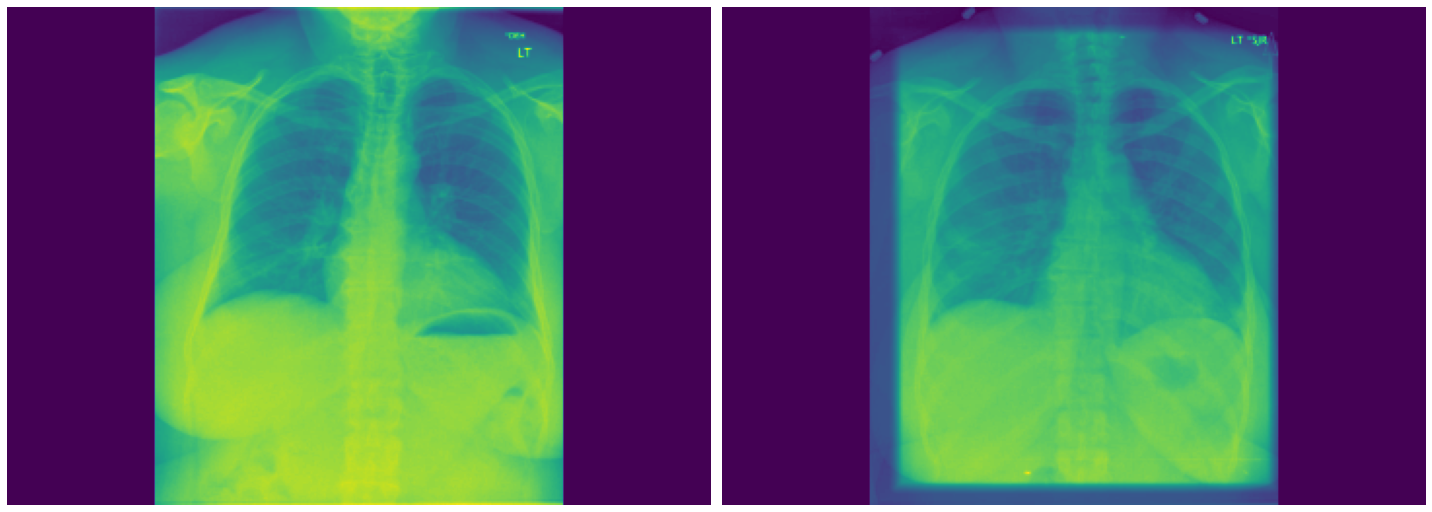

In [218]:
plotImages(correctly_classified_images[:2])

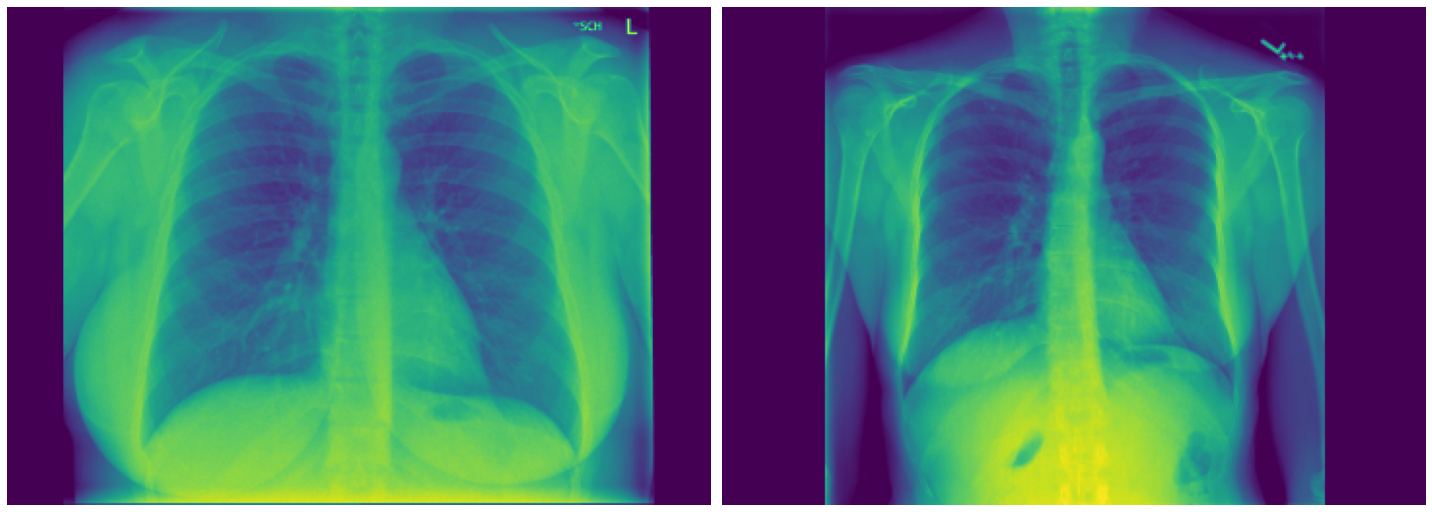

In [219]:
plotImages(correctly_classified_images[2:4])

In [220]:
correctly_classified_non_covid = []
for i in range(len(y_pred_mod)):
    if y_pred_mod[i] == 0 and y_pred_mod[i] == y_true[i]:
        correctly_classified_non_covid.append(i)

In [221]:
print(len(correctly_classified_non_covid))

664


In [222]:
correctly_classified_non_covid_images = None
for test_images, label in test_data_gen:
    correctly_classified_non_covid_images = tf.gather(test_images, indices=correctly_classified_non_covid, axis=0)

In [225]:
correctly_classified_non_covid_images = tf.reshape(correctly_classified_non_covid_images, (664, IMG_WIDTH, IMG_HEIGHT))

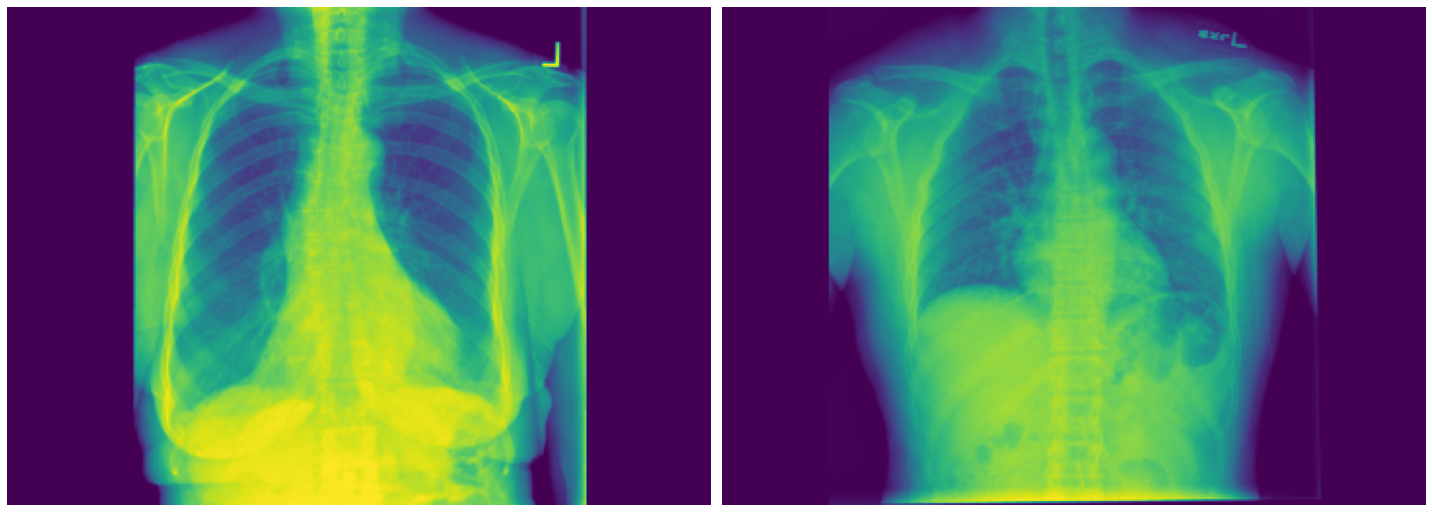

In [227]:
plotImages(correctly_classified_non_covid_images[0:2])

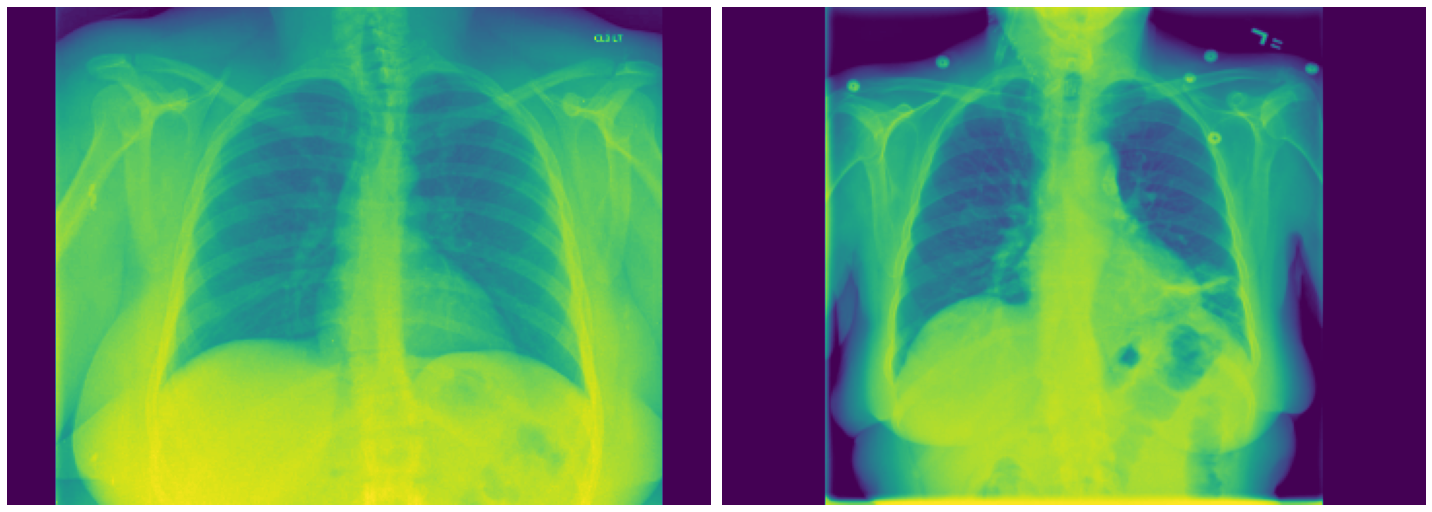

In [229]:
plotImages(correctly_classified_non_covid_images[2:4])